In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
import pdb

In [18]:
#判断cuda是否可用，并设置floattensor默认值为cuda上的tensor
'''
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:",torch.cuda.get_device_name(0))
    pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''

'\nif torch.cuda.is_available():\n    torch.set_default_tensor_type(torch.cuda.FloatTensor)\n    print("using cuda:",torch.cuda.get_device_name(0))\n    pass\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n'

第一个数字(标签)等于1代表超对称信号，等于0代表背景噪声。
剩下18个数字，对应18个对撞事例末态特征取值，详见
https://www.nature.com/articles/ncomms5308


In [19]:
#使用dataset载入数据集
class SusyDataset(Dataset):
    
    def __init__(self,path):
        self.susy = pd.read_csv(path)
        pass
    
    def __len__(self):
        return len(self.susy)
        pass
    
    def __getitem__(self,index):
        label = int(self.susy.iloc[index,0])
        target = torch.FloatTensor([0,0])
        target[label] = 1
        feature = torch.FloatTensor(self.susy.iloc[index,1:])
        return label,feature,target
        pass
    
    def plot_feature(self,index):
        feature = self.susy.iloc[index,1:]
        plt.hist(feature,bins = 18)
        plt.style.use("ggplot")
        plt.xlabel(index)
        plt.ylabel("feature")
        plt.show()
        



In [20]:
#构建神经网络
class DNN(nn.Module):
    
    def __init__(self,inode = 18,hnode1 = 100,hnode2 = 100,hnode3 = 100,onode = 2):
        super(DNN,self).__init__()
        self.fc1 = nn.Linear(inode,hnode1)
        self.fc2 = nn.Linear(hnode1,hnode2)
        self.fc3 = nn.Linear(hnode3,hnode3)
        self.fc4 = nn.Linear(hnode3,onode)
        self.acf = nn.ReLU()
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(),lr = 0.001)
        #记录训练进展的计数器和列表
        self.counter = 0
        self.progress = []
        pass
    
    def forward(self,x):
        x = self.acf(self.fc1(x))
        x = self.acf(self.fc2(x))
        x = self.acf(self.fc3(x))
        x = self.fc4(x)
        return x
        pass
    
    def train(self,inputs,targets):
        outputs = self.forward(inputs)
        loss = self.loss_func(outputs,targets)
        # 每隔十个训练样本将损失值添加进列表
        self.counter += 1
        if(self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if(self.counter % 10000 == 0):
            print("counter = ",self.counter)
            pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns = ['loss'])
        df.plot(ylim = (0,1.0), figsize = (16,8), alpha = 0.1, marker = '.',
               grid = True, yticks = (0,0.25,0.5))
        pass

In [21]:
dnn = DNN()
dnn

DNN(
  (fc1): Linear(in_features=18, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
  (acf): ReLU()
  (loss_func): MSELoss()
)

In [22]:
#载入训练集
train = SusyDataset("train.csv")

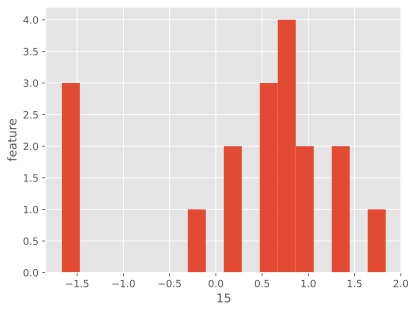

In [24]:
train.plot_feature(15)

In [26]:
#训练10个epoch并记录时间
epochs = 10
for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label,feature,target in train:
        dnn.train(feature,target)
        pass
    pass

training epoch 1 of 10
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
training epoch 2 of 10
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
training epoch 3 of 10
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
training epoch 4 of 10
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
training epoch 5 of 10
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
training epoch 6 of 10
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
training epoch 7 of 10
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
training epoch 8 of 10
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
training epoch 9 of 10
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter = 

In [27]:
torch.save(dnn.state_dict(),"2024-01-09.pt")

In [28]:
#载入测试集
test = SusyDataset("test.csv")

<Axes: >

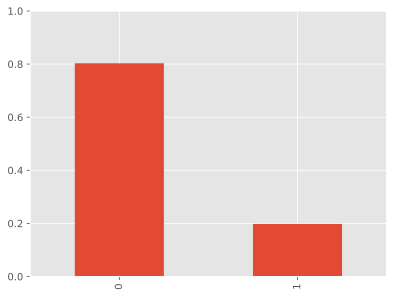

In [36]:
#查看训练之后的dnn判别能力
record = 1
feature = test[record][1]
out = dnn.forward(feature).cpu()
pd.DataFrame(out.detach().numpy()).plot(kind = "bar",legend = False,ylim = (0,1))

In [31]:
dnn.plot_progress()

In [34]:
#计算准确率
score = 0
item = 0
for label,feature,target in test:
    answer = dnn.forward(feature).cpu().detach().numpy()
    if(answer.argmax() == label):
        score += 1
        pass
    item += 1
    pass
print(f"正确个数为：{score}，总个数为：{item}")
print(f"正确率为：{score/item}")

正确个数为：39695，总个数为：50000
正确率为：0.7939
